In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.tree as tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, f1_score, accuracy_score
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [2]:
#Titanic survival data set
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### I followed all data preprocessing steps in this article.
https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9

RangeIndex tells that there are 891 entries, but Age, Cabin, and Embarked have fewer than that, suggesting that these 3 columns have null/missing values. 

To  fix missing values in these variables:
- Missing age: Data is grouped by a passenger’s sex, class, and title, fill the missing age with then median age by each group.
- Missing Cabin: Fill Cabin with "U" for unknown.
- Missing Embarked: Fill with the most frequent point of embarkment.

In [3]:
# create a new feature to extract title names from the column of "Name"
data['Title'] = data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [4]:
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

# map the normalized titles to the current titles 
data.Title = data.Title.map(normalized_titles)
# view value counts for the normalized titles
print(data.Title.value_counts())

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64


In [48]:
# group by Sex, Pclass, and Title 
grouped = data.groupby(['Sex','Pclass', 'Title'])  
# view the median Age by the grouped features 
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royalty    40.5
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royalty    40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64

In [49]:
# apply the grouped median value on the Age NaN
data.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

In [50]:
# fill Cabin NaN with U for unknown
data.Cabin = data.Cabin.fillna('U')
# find most frequent Embarked value and store in variable
most_embarked = data.Embarked.value_counts().index[0]

# fill NaN with most_embarked value
data.Embarked = data.Embarked.fillna(most_embarked)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


Following the steps in this article, two new features are created: Family size per passenger.The assumption is that it is more difficult for a larger family to secure a spot on a life boat, compared to a smaller size family. 

In [51]:
# size of families (including the passenger)
data['FamilySize'] = data.Parch + data.SibSp + 1

Another feature is the Cabin feature. The first letter of the Cabin is extracted to represent the Cabin feature. A Kaggle discussion mentions that the first letter of the cabin indicates deck.(https://www.kaggle.com/c/titanic/discussion/4693) Also, pclass roughly matches the deck - that is, first class has the top decks (A-E), second class (D-F), and thrid class (E-G). The assumption is that passengers with a higher deck/pclass have a higher possibility to survive, because they are closer to lifeboats.

In [52]:
# map first letter of cabin to itself
data.Cabin = data.Cabin.map(lambda x: x[0])

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
FamilySize     891 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 97.5+ KB


In [54]:
# Convert categorical features into dummy variables.
# Convert the male and female groups to integer form
data.Sex = data.Sex.map({"male": 0, "female":1})
# create dummy variables for categorical features
pclass_dummies = pd.get_dummies(data.Pclass, prefix="Pclass")
title_dummies = pd.get_dummies(data.Title, prefix="Title")
cabin_dummies = pd.get_dummies(data.Cabin, prefix="Cabin")
embarked_dummies = pd.get_dummies(data.Embarked, prefix="Embarked")
# concatenate dummy columns with main dataset
data_dummies = pd.concat([data, pclass_dummies, title_dummies, cabin_dummies, embarked_dummies], axis=1)

# drop categorical fields
data_dummies.drop(['Pclass', 'Title', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

data_dummies.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,22.0,1,0,7.2500,2,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,2,1,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,1,26.0,0,0,7.9250,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,4,1,1,35.0,1,0,53.1000,2,1,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,0,35.0,0,0,8.0500,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [55]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 29 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Sex              891 non-null int64
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
FamilySize       891 non-null int64
Pclass_1         891 non-null uint8
Pclass_2         891 non-null uint8
Pclass_3         891 non-null uint8
Title_Master     891 non-null uint8
Title_Miss       891 non-null uint8
Title_Mr         891 non-null uint8
Title_Mrs        891 non-null uint8
Title_Officer    891 non-null uint8
Title_Royalty    891 non-null uint8
Cabin_A          891 non-null uint8
Cabin_B          891 non-null uint8
Cabin_C          891 non-null uint8
Cabin_D          891 non-null uint8
Cabin_E          891 non-null uint8
Cabin_F          891 non-null uint8
Cabin_G          891 non-null uint8
Cabin_T          891 non-nu

In [56]:
Xdf=data_dummies[['Sex','Age','SibSp','Parch','Fare','FamilySize','Pclass_1','Pclass_2','Pclass_3',
                'Title_Master','Title_Miss','Title_Mr','Title_Mrs','Title_Officer','Title_Royalty','Cabin_A','Cabin_B',         
                'Cabin_C','Cabin_D','Cabin_E','Cabin_F','Cabin_G','Cabin_T','Cabin_U','Embarked_C','Embarked_Q','Embarked_S']]
Ydf=data_dummies[['Survived']]

In [57]:
X=Xdf.values
Y=Ydf.values

In [58]:
# Split data into train and  test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
print ("Training set in Titanic survival classification model has {} samples.".format(X_train.shape[0]))
print ("Testing set in Titanic survival classification model has {} samples.".format(X_test.shape[0]))

Training set in Titanic survival classification model has 668 samples.
Testing set in Titanic survival classification model has 223 samples.


In [59]:
# Decision Tree
import timeit
import time
# Baseline (no pruning)

start_time = timeit.default_timer()

decisiontree0 = DecisionTreeClassifier(random_state=0)
decisiontree0.fit(X_train, y_train)
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer() 

Y_pred0 = decisiontree0.predict(X_test)
end_time = timeit.default_timer()
pred_time = end_time - start_time

acctrain_decisiontree0 = round(decisiontree0.score(X_train, y_train), 6)

print('Accuracy score (train set, baseline - unpruned, no cross validation):', acctrain_decisiontree0)
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))  

Accuracy score (train set, baseline - unpruned, no cross validation): 0.988024
Model Training Time (s):   0.00345
Model Prediction Time (s): 0.00030



In [60]:
acctest_decisiontree0 = round(accuracy_score(Y_pred0, y_test), 3)
print('Accuracy score (test set, baseline - unpruned):', acctest_decisiontree0)
auc_decisiontree0 = round(roc_auc_score(Y_pred0, y_test),3)
print('Accuracy score (test set, baseline - unpruned):', auc_decisiontree0)

Accuracy score (test set, baseline - unpruned): 0.798
Accuracy score (test set, baseline - unpruned): 0.788


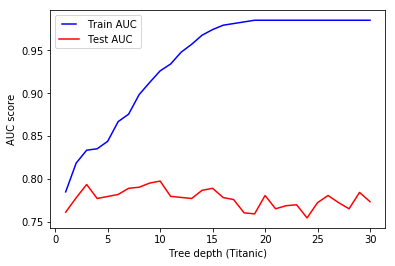

In [19]:
# Decision Tree Parameter Tuning - max depth:
max_depths = np.linspace(1, 30, 30, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt= DecisionTreeClassifier( max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth (Titanic)')
plt.show()

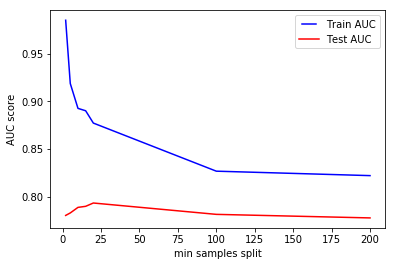

In [21]:
# chart does not report in the final report.
#min_samples_splits = np.linspace(0.0001,1,40, endpoint=True)
min_samples_splits = (2,5,10,15,20,100,200)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')

plt.show()


In [22]:
# Decision Tree (some pruning, Grid Search)

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
#grid search
start_time=time.time()

max_depth_arr = range(1,10,1)
min_samples_split_arr = range(2,10,1)

parameters= [{'max_depth': max_depth_arr, 'min_samples_split':min_samples_split_arr}]

gs_dt=GridSearchCV(estimator=decisiontree0,param_grid=parameters,scoring = 'roc_auc', n_jobs=-1,cv=5)
gs_dt.fit(X_train,y_train)

print("process time total:{:.2f} seconds".format(time.time()-start_time))


process time total:1.62 seconds


In [23]:
print("best score: %s" % gs_dt.best_score_)
print("best param: %s" % gs_dt.best_params_)

best score: 0.843308884934
best param: {'max_depth': 4, 'min_samples_split': 8}


process time total:1549467656.27 seconds


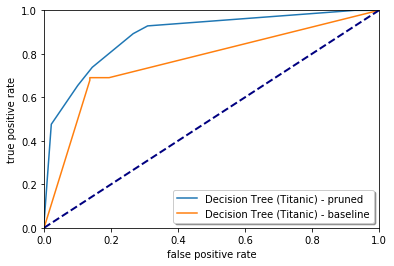

Model Training Time (s):   0.00173
Model Prediction Time (s): 0.00022



In [54]:
#Re-run DT with the best parameters reported in Grid Search
#start_time=time.time()
start_time = timeit.default_timer()

decisiontree1 = DecisionTreeClassifier(max_depth=4, min_samples_split=8)
print("process time total:{:.2f} seconds".format(time.time()-start_time))
# Training
decisiontree1.fit(X_train, y_train)
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer()
Y_pred = decisiontree1.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time

Y_pred_proba = decisiontree1.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = metrics.roc_curve(y_test,Y_pred_proba)

Y_pred0_proba=decisiontree0.predict_proba(X_test)[:,1]
fpr0, tpr0, thresholds0=metrics.roc_curve(y_test, Y_pred0_proba)

# Plotting and printing
plt.plot(fpr,tpr,label='Decision Tree (Titanic) - pruned')
plt.plot(fpr0,tpr0,label='Decision Tree (Titanic) - baseline')
plt.xlabel ('false positive rate')
plt.ylabel ('true positive rate')
plt.legend(loc='lower right',shadow=True)
lw=2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))  
#print("roc_auc score: %s" % metrics.roc_auc_score(y_test,Y_pred_proba))
#print("accuracy score: %s" % metrics.accuracy_score(y_test,Y_pred))
#print("precision score: %s" % metrics.precision_score(y_test,Y_pred))
#print("recall score: %s" % metrics.recall_score(y_test,Y_pred))
#print("F1 score: %s" % metrics.f1_score(y_test,Y_pred))

In [25]:
#acctrain_decisiontree1 = round(decisiontree1.score(X_train, y_train), 3)
#print('Accuracy score (train set, pruned, no cross validation):', acctrain_decisiontree1)

Accuracy score (train set, pruned, no cross validation): 0.859


In [53]:
acctest_decisiontree1 = round(accuracy_score(Y_pred, y_test), 3)
print('Accuracy score (test set, pruned):', acctest_decisiontree1)
roc_dt1 = round(roc_auc_score(Y_pred, y_test),3)
print('ROC score (test set, baseline - unpruned):', roc_dt1)

Accuracy score (test set, pruned): 0.807
ROC score (test set, baseline - unpruned): 0.804


In [35]:
# cross validation (train set)
start_time=time.time()
scoresDT = cross_val_score(decisiontree1, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs=-1)
print('Decision Tree Accuracy Train Set (CV/Mean): ', np.mean(scoresDT))
print("process time total:{:.2f} seconds".format(time.time()-start_time))
print('Decision Tree Accuracy Train Set (CV/SD): ', np.std(scoresDT))
# The cross_val_score returns the accuracy for all the folds

Decision Tree Accuracy Train Set (CV/Mean):  0.843310157083
process time total:2.70 seconds
Decision Tree Accuracy Train Set (CV/SD):  0.0362044373441


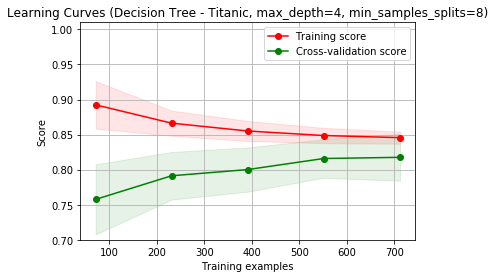

In [61]:
# learning curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
title = "Learning Curves (Decision Tree - Titanic, max_depth=4, min_samples_splits=8)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier(max_depth=4, min_samples_split=8)

plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

In [33]:
print(classification_report(y_test,Y_pred))

             precision    recall  f1-score   support

          0       0.81      0.90      0.85       139
          1       0.80      0.65      0.72        84

avg / total       0.81      0.81      0.80       223



In [34]:
print(classification_report(y_test,Y_pred0))

             precision    recall  f1-score   support

          0       0.81      0.86      0.84       139
          1       0.75      0.67      0.70        84

avg / total       0.79      0.79      0.79       223



https://perso.limsi.fr/annlor/enseignement/ensiie/Intro_ML_Python.pdf
MLPClassifier

In [62]:
# Neural Networks
# Baseline (no pruning)
start_time = timeit.default_timer()

neuraln0 = MLPClassifier(random_state=1)
neuraln0.fit(X_train, y_train.ravel())
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer()
Y_pred0 = neuraln0.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time

acctrain_neuraln0 = round(neuraln0.score(X_train, y_train), 3)
print('Accuracy score (train set, baseline - no cross validation):', acctrain_neuraln0)
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))  


Accuracy score (train set, baseline - no cross validation): 0.846
Model Training Time (s):   0.24109
Model Prediction Time (s): 0.00030



In [29]:
acctest_neuraln0 = round(accuracy_score(Y_pred0, y_test) , 3)
print('Accuracy score (test set, baseline):', acctest_neuraln0)
auc_neuraln0 = round(roc_auc_score(Y_pred0, y_test),3)
print('Accuracy score (test set, baseline - unpruned):', auc_neuraln0)

Accuracy score (test set, baseline): 0.816
Accuracy score (test set, baseline - unpruned): 0.805


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.81427491019096243, 0.79927207411609003, 0.66202495745887702]
[0.7910243233984241, 0.79586330935251792, 0.65202124015073648]


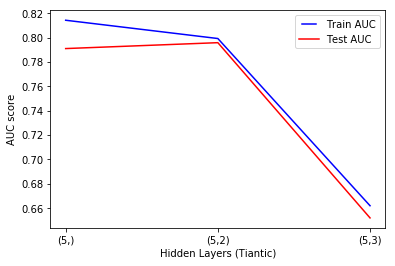

In [35]:
# NN Parameter Tuning - hidden layer:
hidden_layer_sizes =  [(5,), (5,2), (5,3)]
train_results = []
test_results = []
for hidden_layer_sizes in hidden_layer_sizes:
    nn= MLPClassifier( hidden_layer_sizes=hidden_layer_sizes)
    nn.fit(X_train, y_train.ravel())
    train_pred = nn.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = nn.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

print(train_results)
print(test_results)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(["(5,)" ,"(5,2)","(5,3)" ], train_results, 'b', label='Train AUC')
line2, = plt.plot(["(5,)","(5,2)","(5,3)"], test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Hidden Layers (Tiantic)')
plt.show()

C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


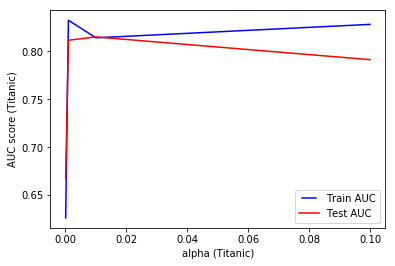

In [51]:
alpha_arr = [0.0001,0.001,0.01,0.1]
train_results = []
test_results = []
for alpha in alpha_arr:
    nn= MLPClassifier( alpha=alpha)
    nn.fit(X_train, y_train)
    train_pred = nn.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = nn.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(alpha_arr, train_results, 'b', label='Train AUC')
line2, = plt.plot(alpha_arr, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score (Titanic)')
plt.xlabel('alpha (Titanic)')

plt.show()


In [40]:
start_time=time.time()


MLP = MLPClassifier()
mlp_param_grid = {'hidden_layer_sizes' : [(5,),(8,),(20,),(100,)],
                  'solver' : ['lbfgs','adam'],
                   'max_iter':[1000]}

gsMLP = GridSearchCV(MLP,param_grid = mlp_param_grid, cv=5, scoring='accuracy',n_jobs=-1,verbose=1)
gsMLP.fit(X_train,y_train)
MLP_best = gsMLP.best_estimator_

#gsMLP.best_score_

print("process time total:{:.2f} seconds".format(time.time()-start_time))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.5s finished
C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


process time total:7.02 seconds


In [41]:
print("best score: %s" % gsMLP.best_score_)
print("best param: %s" % gsMLP.best_params_)

best score: 0.832335329341
best param: {'hidden_layer_sizes': (8,), 'max_iter': 1000, 'solver': 'lbfgs'}


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


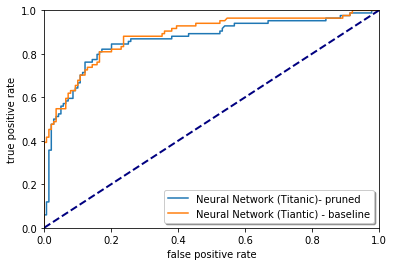

Model Training Time (s):   0.29766
Model Prediction Time (s): 0.00022



In [55]:
#Re-run DT with the best parameters reported in Grid Search

neuraln1 = MLPClassifier(max_iter=1000,solver='lbfgs',hidden_layer_sizes=[8,],random_state=1)

# Training
start_time = timeit.default_timer()

neuraln1.fit(X_train, y_train)
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer()
Y_pred = neuraln1.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time

Y_pred_proba = neuraln1.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = metrics.roc_curve(y_test,Y_pred_proba)

Y_pred0_proba=neuraln0.predict_proba(X_test)[:,1]
fpr0, tpr0, thresholds0=metrics.roc_curve(y_test, Y_pred0_proba)

pruned_roc_auc= roc_auc_score(y_test, neuraln1.predict(X_test))
baseline_roc_auc = roc_auc_score(y_test, neuraln0.predict(X_test))
# Plotting and printing

#plt.plot(fpr,tpr,label='Neural Network - pruned(area = %0.4f)'% pruned_roc_auc)
#plt.plot(fpr0,tpr0,label='Neural Network - baseline(area = %0.4f)'% baseline_roc_auc)
plt.plot(fpr,tpr,label='Neural Network (Titanic)- pruned')
plt.plot(fpr0,tpr0,label='Neural Network (Tiantic) - baseline')
plt.xlabel ('false positive rate')
plt.ylabel ('true positive rate')
plt.legend(loc='lower right',shadow=True)
lw=2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))  
#print("roc_auc score: %s" % metrics.roc_auc_score(y_test,Y_pred_proba))
#print("accuracy score: %s" % metrics.accuracy_score(y_test,Y_pred))
#print("precision score: %s" % metrics.precision_score(y_test,Y_pred))
#print("recall score: %s" % metrics.recall_score(y_test,Y_pred))
#print("F1 score: %s" % metrics.f1_score(y_test,Y_pred))


In [50]:
acctest_neuraln1 = round(accuracy_score(Y_pred, y_test), 3)
print('Accuracy score (test set, pruned):', acctest_neuraln1)
roc_neuraln1 = round(roc_auc_score(Y_pred, y_test),3)
print('ROC score (test set, baseline - unpruned):', roc_neuraln1)

Accuracy score (test set, pruned): 0.821
ROC score (test set, baseline - unpruned): 0.809


In [47]:
# cross validation (train set)
scoresNN = cross_val_score(neuraln1, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs=-1)
print('Decision Tree Accuracy Train Set (CV/Mean): ', np.mean(scoresNN))
print('Decision Tree Accuracy Train Set (CV/SD): ', np.std(scoresNN))
# The cross_val_score returns the accuracy for all the folds


Decision Tree Accuracy Train Set (CV/Mean):  0.865575451569
Decision Tree Accuracy Train Set (CV/SD):  0.0206225402761


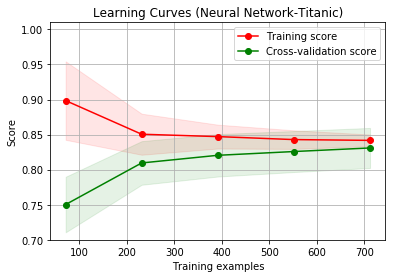

In [63]:
# learning curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
title = "Learning Curves (Neural Network-Titanic)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPClassifier(max_iter=1000,solver='lbfgs',hidden_layer_sizes=[8,],random_state=1)

plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

In [59]:
print(classification_report(y_test,Y_pred))
print(classification_report(y_test,Y_pred0))

             precision    recall  f1-score   support

          0       0.86      0.86      0.86       139
          1       0.76      0.76      0.76        84

avg / total       0.82      0.82      0.82       223

             precision    recall  f1-score   support

          0       0.85      0.86      0.85       139
          1       0.77      0.74      0.75        84

avg / total       0.82      0.82      0.82       223



In [73]:
# Boosting
# Baseline (no pruning)
start_time = timeit.default_timer()

gbc0 = GradientBoostingClassifier()
gbc0.fit(X_train, y_train.ravel())
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer()
Y_pred0 = gbc0.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time

acctrain_gbc0 = round(gbc0.score(X_train, y_train) , 3)
print('Accuracy score (train set, baseline - unpruned, no cross validation):', acctrain_gbc0)
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))  


Accuracy score (train set, baseline - unpruned, no cross validation): 0.898
Model Training Time (s):   0.07404
Model Prediction Time (s): 0.00022



In [74]:
acctest_gbc0 = round(accuracy_score(Y_pred0, y_test) , 3)
print('Accuracy score (test set, baseline):', acctest_gbc0)
auc_gbc0 = round(roc_auc_score(Y_pred0, y_test),3)
print('Accuracy score (test set, baseline - unpruned):', auc_gbc0)

Accuracy score (test set, baseline): 0.834
Accuracy score (test set, baseline - unpruned): 0.829


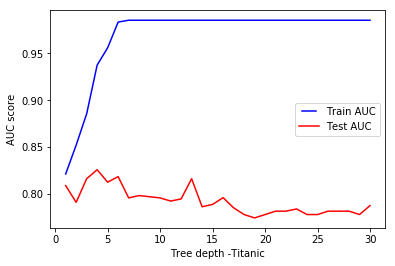

In [75]:
# GBC Parameter Tuning - max depth:
max_depths = np.linspace(1, 30, 30, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    gbc= GradientBoostingClassifier( max_depth=max_depth)
    gbc.fit(X_train, y_train.ravel())
    train_pred = gbc.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = gbc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth -Titanic')
plt.show()


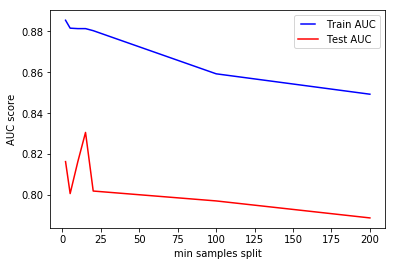

In [246]:
min_samples_splits = (2,5,10,15,20,100,200)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    gbc = GradientBoostingClassifier(min_samples_split=min_samples_split)
    gbc.fit(X_train, y_train.ravel())
    train_pred = gbc.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = gbc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')

plt.show()

In [78]:
# GBC (some pruning, Grid Search)

#grid search
import time
start_time=time.time()

max_depth_arr = range(1,8,1)
min_samples_split_arr = range(2,20,2)

parameters= [{'max_depth': max_depth_arr}]


gs_gbc=GridSearchCV(estimator=gbc0,param_grid=parameters,scoring = 'roc_auc', n_jobs=-1,cv=5)
gs_gbc.fit(X_train,y_train)

print("process time total:{:.2f} seconds".format(time.time()-start_time))


process time total:2.62 seconds


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
print("best score: %s" % gs_gbc.best_score_)
print("best param: %s" % gs_gbc.best_params_)


best score: 0.867096386082
best param: {'max_depth': 3}


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


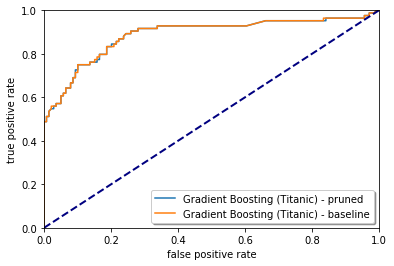

Model Training Time (s):   0.07146
Model Prediction Time (s): 0.00022



In [80]:
#Re-run GBC with the best parameters reported in Grid Search
start_time = timeit.default_timer()
#gbc1=GradientBoostingClassifier(max_depth=6, learning_rate=0.01, min_samples_split=14, n_estimators=200)
gbc1=GradientBoostingClassifier(max_depth=3)
# Training
gbc1.fit(X_train, y_train)
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer()
Y_pred =gbc1.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time


pruned_roc_auc= roc_auc_score(y_test, gbc1.predict(X_test))
Y_pred_proba = gbc1.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = metrics.roc_curve(y_test,Y_pred_proba)

baseline_roc_auc = roc_auc_score(y_test, gbc0.predict(X_test))
Y_pred0_proba=gbc0.predict_proba(X_test)[:,1]
fpr0, tpr0, thresholds0=metrics.roc_curve(y_test, Y_pred0_proba)

# Plotting and printing
#plt.plot(fpr,tpr,label='Gradient Boosting - pruned(area = %0.4f)'% pruned_roc_auc)
#plt.plot(fpr0,tpr0,label='Gradient Boosting - baseline(area = %0.4f)'% baseline_roc_auc)
plt.plot(fpr,tpr,label='Gradient Boosting (Titanic) - pruned')
plt.plot(fpr0,tpr0,label='Gradient Boosting (Titanic) - baseline')
plt.xlabel ('false positive rate')
plt.ylabel ('true positive rate')
plt.legend(loc='lower right',shadow=True)
lw=2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))  
#print("roc_auc score: %s" % metrics.roc_auc_score(y_test,Y_pred_proba))
#print("accuracy score: %s" % metrics.accuracy_score(y_test,Y_pred))
#print("precision score: %s" % metrics.precision_score(y_test,Y_pred))
#print("recall score: %s" % metrics.recall_score(y_test,Y_pred))
#print("F1 score: %s" % metrics.f1_score(y_test,Y_pred))


In [81]:
acctest_gbc1 = round(accuracy_score(Y_pred, y_test) , 3)
print('Accuracy score (test set, pruned):', acctest_gbc1)
roc_gbc1 = round(roc_auc_score(Y_pred, y_test),3)
print('ROC score (test set, baseline - unpruned):', roc_gbc1)

Accuracy score (test set, pruned): 0.839
ROC score (test set, baseline - unpruned): 0.835


In [82]:
# cross validation (train set)
scoresGBC = cross_val_score(gbc1, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs=-1)
print('GBC Accuracy Train Set (CV/Mean): ', np.mean(scoresGBC))
print('GBC Accuracy Train Set (CV/SD): ', np.std(scoresGBC))
# The cross_val_score returns the accuracy for all the folds


GBC Accuracy Train Set (CV/Mean):  0.867374829857
GBC Accuracy Train Set (CV/SD):  0.0276671817206


In [83]:
print(classification_report(y_test,Y_pred))
print(classification_report(y_test,Y_pred0))


             precision    recall  f1-score   support

          0       0.85      0.91      0.88       139
          1       0.82      0.73      0.77        84

avg / total       0.84      0.84      0.84       223

             precision    recall  f1-score   support

          0       0.84      0.90      0.87       139
          1       0.81      0.73      0.77        84

avg / total       0.83      0.83      0.83       223



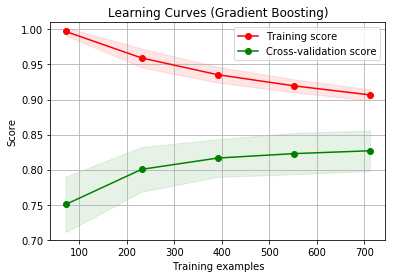

In [64]:
# learning curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
title = "Learning Curves (Gradient Boosting)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GradientBoostingClassifier(max_depth=3)

plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

In [66]:
# SVM
#svc=SVC(C=30, gamma=0.01)
# Baseline (no pruning)
#from sklearn.svm import SVC, LinearSVC
start_time = timeit.default_timer()

from sklearn.svm import SVC
svc0 = SVC()
svc0.fit(X_train, y_train)
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer()

Y_pred0 = svc0.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time

acctrain_svc0 = round(svc0.score(X_train, y_train) ,3)
print('Accuracy score (train set, baseline - unpruned, no cross validation):', acctrain_svc0)
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time)) 

Accuracy score (train set, baseline - unpruned, no cross validation): 0.876
Model Training Time (s):   0.15722
Model Prediction Time (s): 0.00030



C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
acctest_svc0 = round(accuracy_score(Y_pred0, y_test) , 3)
print('Accuracy score (test set, baseline - unpruned):', acctest_svc0)
auc_svc0 = round(roc_auc_score(Y_pred0, y_test),3)
print('Accuracy score (test set, baseline - unpruned):', auc_svc0)

Accuracy score (test set, baseline - unpruned): 0.735
Accuracy score (test set, baseline - unpruned): 0.718


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


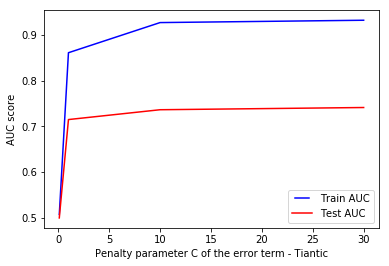

In [88]:
# SVM Parameter Tuning - C:
C_arr=[0.1,1,10,30]
train_results = []
test_results = []
for C in C_arr:
   svc= SVC(C=C)
   svc.fit(X_train, y_train)
   train_pred = svc.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = svc.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(C_arr, train_results, 'b', label='Train AUC')
line2, = plt.plot(C_arr, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Penalty parameter C of the error term - Tiantic')
plt.show()


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


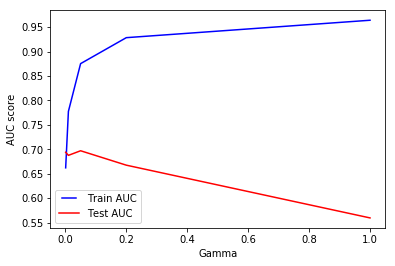

In [365]:
# SVM Parameter Tuning - gamma:
gamma_arr=[0.001,0.01,0.05,0.2,1]
train_results = []
test_results = []
for gamma in gamma_arr:
   svc= SVC(gamma=gamma)
   svc.fit(X_train, y_train)
   train_pred = svc.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = svc.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(gamma_arr, train_results, 'b', label='Train AUC')
line2, = plt.plot(gamma_arr, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Gamma')
plt.show()

[0.63979013045944411, 0.63979013045944411]
[0.77676430284343956, 0.71475676601575877]


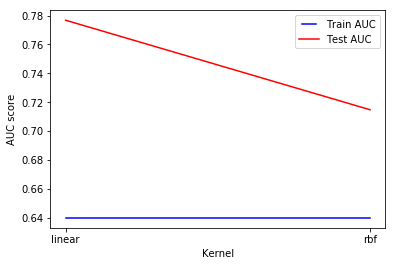

In [69]:
#SVM Parameter Tuning - kernel:
kernel_arr =  ['linear', 'rbf']
train_results = []
test_results = []
for kernel in kernel_arr:
    svc=SVC(kernel=kernel)
    svc.fit(X_train, y_train.ravel())
    train_pred = knn.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = svc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

print(train_results)
print(test_results)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(['linear', 'rbf' ], train_results, 'b', label='Train AUC')
line2, = plt.plot(['linear', 'rbf'], test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Kernel')
plt.show()

In [91]:
# SVM (some pruning, Grid Search)

#grid search
import time
start_time=time.time()

C_arr = [0.1,1,10,30]
gamma_arr=[0.001,0.01,0.05,0.2,1]
kernel_arr=['linear', 'rbf']

parameters= [{'C': C_arr, 'gamma':gamma_arr, 'kernel':kernel_arr}]


gs_svc=GridSearchCV(estimator=svc0,param_grid=parameters,scoring = 'roc_auc', n_jobs=-1,cv=5)
gs_svc.fit(X_train,y_train)

print("process time total:{:.2f} seconds".format(time.time()-start_time))


process time total:284.28 seconds


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [92]:
print("best score: %s" % gs_svc.best_score_)
print("best param: %s" % gs_svc.best_params_)

best score: 0.85950280352
best param: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


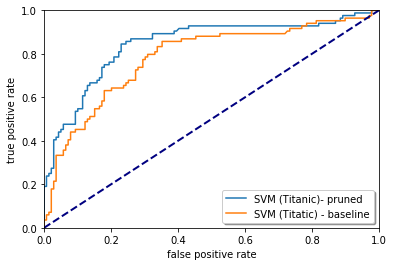

Model Training Time (s):   88.06723
Model Prediction Time (s): 0.00022



In [101]:
#Re-run GBC with the best parameters reported in Grid Search
start_time = timeit.default_timer()
svc1=SVC(C=30, gamma=0.001, kernel='linear')
svc0=SVC()

#trick sklearn:
svc1.probability = True
svc0.probability= True

# Training
svc1.fit(X_train, y_train)
end_time = timeit.default_timer()
training_time = end_time - start_time
start_time = timeit.default_timer()
Y_pred =svc1.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time

svc0.fit(X_train, y_train)
#pruned_roc_auc= roc_auc_score(y_test, svc1.predict(X_test))
Y_pred_proba = svc1.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = metrics.roc_curve(y_test,Y_pred_proba)

#baseline_roc_auc = roc_auc_score(y_test, svc0.predict(X_test))
Y_pred0_proba=svc0.predict_proba(X_test)[:,1]
fpr0, tpr0, thresholds0=metrics.roc_curve(y_test, Y_pred0_proba)

# Plotting and printing

plt.plot(fpr,tpr,label='SVM (Titanic)- pruned')
plt.plot(fpr0,tpr0,label='SVM (Titatic) - baseline')
plt.xlabel ('false positive rate')
plt.ylabel ('true positive rate')
plt.legend(loc='lower right',shadow=True)
lw=2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))  
#print("roc_auc score: %s" % metrics.roc_auc_score(y_test,Y_pred_proba))
#print("accuracy score: %s" % metrics.accuracy_score(y_test,Y_pred))
#print("precision score: %s" % metrics.precision_score(y_test,Y_pred))
#print("recall score: %s" % metrics.recall_score(y_test,Y_pred))
#print("F1 score: %s" % metrics.f1_score(y_test,Y_pred))

In [102]:
acctest_svc1 = round(accuracy_score(Y_pred, y_test) , 3)
print('Accuracy score (test set, pruned):', acctest_svc1)
roc_svc1 = round(roc_auc_score(Y_pred, y_test),3)
print('ROC score (test set, baseline - unpruned):', roc_svc1)

Accuracy score (test set, pruned): 0.794
ROC score (test set, baseline - unpruned): 0.78


In [103]:
# cross validation (train set)
scoresSVM = cross_val_score(svc1, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs=-1)
print('SVM Accuracy Train Set (CV/Mean): ', np.mean(scoresSVM))
print('SVM Accuracy Train Set (CV/SD): ', np.std(scoresSVM))
# The cross_val_score returns the accuracy for all the folds


SVM Accuracy Train Set (CV/Mean):  0.853022569253
SVM Accuracy Train Set (CV/SD):  0.0202090242745


In [104]:
print(classification_report(y_test,Y_pred))
print(classification_report(y_test,Y_pred0))


             precision    recall  f1-score   support

          0       0.84      0.83      0.83       139
          1       0.72      0.74      0.73        84

avg / total       0.79      0.79      0.79       223

             precision    recall  f1-score   support

          0       0.78      0.80      0.79       139
          1       0.65      0.63      0.64        84

avg / total       0.73      0.74      0.73       223



In [ ]:
# learning curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
title = "Learning Curves (SVM) -Titanic"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = SVC(C=30, gamma=0.001,kernel='linear')
plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

In [18]:
# KNN
# Baseline (no pruning)
start_time = timeit.default_timer()

knn0=KNeighborsClassifier()
knn0.fit(X_train, y_train)
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer()
Y_pred0 = knn0.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time

acctrain_knn0 = round(knn0.score(X_train, y_train), 3)
print('Accuracy score (train set, baseline - unpruned, no cross validation):', acctrain_knn0)
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))  

Accuracy score (train set, baseline - unpruned, no cross validation): 0.802
Model Training Time (s):   0.00229
Model Prediction Time (s): 0.00041



C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [20]:
acctest_knn0 = round(accuracy_score(Y_pred0, y_test) , 3)
print('Accuracy score (test set, baseline - unpruned):', acctest_knn0)
auc_knn0 = round(roc_auc_score(Y_pred0, y_test),3)
print('Accuracy score (test set, baseline - unpruned):', auc_knn0)

Accuracy score (test set, baseline - unpruned): 0.722
Accuracy score (test set, baseline - unpruned): 0.704


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


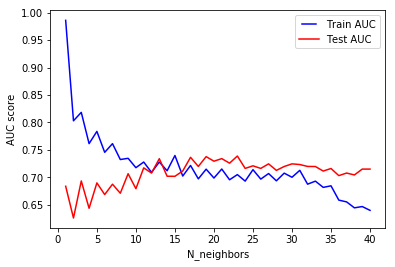

In [26]:
# KNN Parameter Tuning - n_neighbors:
neighbor_arr = np.linspace(1, 40, 40, endpoint=True).astype('int')
train_results = []
test_results = []
for n_neighbors in neighbor_arr:
    knn= KNeighborsClassifier( n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    train_pred = knn.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = knn.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbor_arr, train_results, 'b', label='Train AUC')
line2, = plt.plot(neighbor_arr, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('N_neighbors')
plt.show()


In [28]:
# KNN (some pruning, Grid Search)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import time
start_time=time.time()

neighbor_arr = np.linspace(1, 40, 40, endpoint=True).astype('int')

parameters= [{'n_neighbors': neighbor_arr}]

gs_knn=GridSearchCV(estimator=knn0,param_grid=parameters,scoring = 'roc_auc', n_jobs=-1,cv=5)
gs_knn.fit(X_train,y_train)

print("process time total:{:.2f} seconds".format(time.time()-start_time))


process time total:4.09 seconds


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [30]:
print("best score: %s" % gs_knn.best_score_)
print("best param: %s" % gs_knn.best_params_)

best score: 0.743577435131
best param: {'n_neighbors': 18}


C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


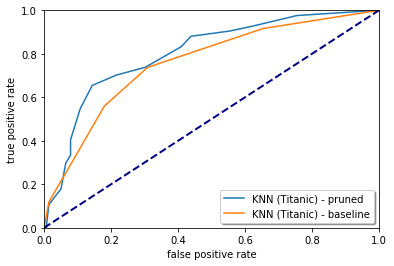

Model Training Time (s):   0.00290
Model Prediction Time (s): 0.00041



In [34]:
#Re-run KNN with the best parameters reported in Grid Search

start_time = timeit.default_timer()

knn1=KNeighborsClassifier(n_neighbors=18)
# Training
knn1.fit(X_train, y_train)
end_time = timeit.default_timer()
training_time = end_time - start_time

start_time = timeit.default_timer()
Y_pred =knn1.predict(X_test)
end_time = timeit.default_timer()
predict_time = end_time - start_time

pruned_roc_auc= roc_auc_score(y_test, knn1.predict(X_test))
Y_pred_proba = knn1.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = metrics.roc_curve(y_test,Y_pred_proba)

baseline_roc_auc = roc_auc_score(y_test, knn0.predict(X_test))
Y_pred0_proba=knn0.predict_proba(X_test)[:,1]
fpr0, tpr0, thresholds0=metrics.roc_curve(y_test, Y_pred0_proba)

# Plotting and printing
plt.plot(fpr,tpr,label='KNN (Titanic) - pruned')
plt.plot(fpr0,tpr0,label='KNN (Titanic) - baseline')
plt.xlabel ('false positive rate')
plt.ylabel ('true positive rate')
plt.legend(loc='lower right',shadow=True)
lw=2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()
print("Model Training Time (s):   "+"{:.5f}".format(training_time))
print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time)) 
#print("roc_auc score: %s" % metrics.roc_auc_score(y_test,Y_pred_proba))
#print("accuracy score: %s" % metrics.accuracy_score(y_test,Y_pred))
#print("precision score: %s" % metrics.precision_score(y_test,Y_pred))
#print("recall score: %s" % metrics.recall_score(y_test,Y_pred))
#print("F1 score: %s" % metrics.f1_score(y_test,Y_pred))

In [35]:
acctest_knn1 = round(accuracy_score(Y_pred, y_test) , 3)
print('Accuracy score (test set, pruned):', acctest_knn1)
roc_knn1 = round(roc_auc_score(Y_pred, y_test),3)
print('ROC score (test set, baseline - unpruned):', roc_knn1)

Accuracy score (test set, pruned): 0.762
ROC score (test set, baseline - unpruned): 0.76


In [37]:
# cross validation (train set)
scoresKNN = cross_val_score(knn1, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs=-1)
print('KNN Accuracy Train Set (CV/Mean): ', np.mean(scoresKNN))
print('KNN Accuracy Train Set (CV/SD): ', np.std(scoresKNN))
# The cross_val_score returns the accuracy for all the folds

KNN Accuracy Train Set (CV/Mean):  0.743700106684
KNN Accuracy Train Set (CV/SD):  0.0493393961146


In [38]:
print(classification_report(y_test,Y_pred))
print(classification_report(y_test,Y_pred0))


             precision    recall  f1-score   support

          0       0.77      0.89      0.82       139
          1       0.75      0.55      0.63        84

avg / total       0.76      0.76      0.75       223

             precision    recall  f1-score   support

          0       0.75      0.82      0.79       139
          1       0.65      0.56      0.60        84

avg / total       0.72      0.72      0.72       223



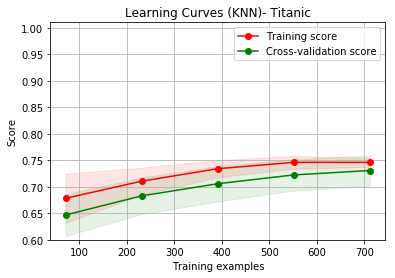

In [43]:
# learning curve

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
title = "Learning Curves (KNN)- Titanic"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = KNeighborsClassifier(n_neighbors=18)
plot_learning_curve(estimator, title, X, Y, ylim=(0.6, 1.01), cv=cv, n_jobs=-1)

plt.show()